# PREPROCESSING

This notebook corresponds to the preprocessing step of this project. The goal of this step is to prepare the data for the next steps of the project. Notice that in this notebook we are always explaining why we are doing each step. For further information based on the decisions we have made, check out the report.

In [143]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from datetime import datetime
from sklearn import preprocessing

In [144]:
# read data
data = pd.read_csv('../data/US_Accidents_March23_sampled_500k.csv')

## Section 1: General inspection 

Let's start by looking at the rows and columns of the dataset.

In [145]:
data.shape

(500000, 46)

Let's see the variables in our data and decide which will we our target variable.

In [146]:
data.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description',
       'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

## Section 2: First Feature Selection

Working with that amount of data, could be fatal for our computational resources while doing other stuff in preprocessing. So, we will do a first selection of the features that we believe are the most important for our model. Notice that the selection is based on the data description and the importance of the features in the model according to the predictor, which is Severity. 

In [147]:
data = data.drop(columns=['ID', 'Source', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 
                          'Weather_Timestamp', 'End_Lat','End_Lng','Airport_Code','Wind_Chill(F)', 'Wind_Direction', 'Wind_Speed(mph)',
                          'Precipitation(in)', 'Weather_Condition', 'Bump', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
                          'Astronomical_Twilight'])

The time is encoded as string, so it may cause problems when we impute the missing values with the KNN algorithm. In order to avoid these problems we will create new variables that will save the information given by these columns and then we will take them off the dataset.

In [148]:
time_elapsed: list[int] = list()
years: list[int] = list()
months: list[int] = list()
days: list[int] = list()
hours: list[int] = list()
weekdays: list[int] = list()

for start_time, end_time in zip(data['Start_Time'], data['End_Time']):

    years.append(int(start_time[:4]))
    months.append(int(start_time[5:7]))
    days.append(int(start_time[8:10]))
    hours.append(int(start_time[11:13]))

    start_time_p = start_time.split('.')[0]
    end_time_p = end_time.split('.')[0]

    weekdays.append(datetime.strptime(start_time_p, '%Y-%m-%d %H:%M:%S').weekday())
    start = datetime.strptime(start_time_p, '%Y-%m-%d %H:%M:%S')
    end = datetime.strptime(end_time_p, '%Y-%m-%d %H:%M:%S')

    time_elapsed.append((end-start).seconds)

data['Time_Difference'] = pd.DataFrame(time_elapsed)
data['Year'] = pd.DataFrame(years)
data['Month'] = pd.DataFrame(months)
data['Day'] = pd.DataFrame(days)
data['Hour'] = pd.DataFrame(hours)
data['Weekday'] = pd.DataFrame(weekdays)

data = data.drop(columns = ['End_Time', 'Start_Time'])

In general, we have selected features that are most likely to be related to the severity of the accident. Variables which are not related to the severity of the accident were not selected, such as the ID of the accident. We have also took into account variables that are duplicated. For instance, if we have the latitude and longitude of the accident, we do not need the address of the accident.

In [149]:
data.shape

(500000, 26)

From 46 features, we have selected 22 features.

## Section 3: Dealing with missing values

First of all, let's see the summary of our dataset now in order to identify possibles Nan's

In [150]:
pd.set_option('display.max_columns', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Severity         500000 non-null  int64  
 1   Start_Lat        500000 non-null  float64
 2   Start_Lng        500000 non-null  float64
 3   Distance(mi)     500000 non-null  float64
 4   Temperature(F)   489534 non-null  float64
 5   Humidity(%)      488870 non-null  float64
 6   Pressure(in)     491072 non-null  float64
 7   Visibility(mi)   488709 non-null  float64
 8   Amenity          500000 non-null  bool   
 9   Crossing         500000 non-null  bool   
 10  Give_Way         500000 non-null  bool   
 11  Junction         500000 non-null  bool   
 12  No_Exit          500000 non-null  bool   
 13  Railway          500000 non-null  bool   
 14  Roundabout       500000 non-null  bool   
 15  Station          500000 non-null  bool   
 16  Stop             500000 non-null  bool

The target value severity is categorical and Python identifies it as an int, so lets correct this. Also for the bool variables, let's make them an object. Some time variables will be converted to object too, those who take discrete values into an small set, like Day (1-31), Hour (0-23), Weekday (0-6) and Month(1-12).

In [151]:
data.Severity = data.Severity.astype('object')
for column in ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop','Weekday','Hour','Day','Month']:
    data[column] = data[column].astype('object')

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Severity         500000 non-null  object 
 1   Start_Lat        500000 non-null  float64
 2   Start_Lng        500000 non-null  float64
 3   Distance(mi)     500000 non-null  float64
 4   Temperature(F)   489534 non-null  float64
 5   Humidity(%)      488870 non-null  float64
 6   Pressure(in)     491072 non-null  float64
 7   Visibility(mi)   488709 non-null  float64
 8   Amenity          500000 non-null  object 
 9   Crossing         500000 non-null  object 
 10  Give_Way         500000 non-null  object 
 11  Junction         500000 non-null  object 
 12  No_Exit          500000 non-null  object 
 13  Railway          500000 non-null  object 
 14  Roundabout       500000 non-null  object 
 15  Station          500000 non-null  object 
 16  Stop             500000 non-null  obje

Now, let's visualise the missing values in the dataset.

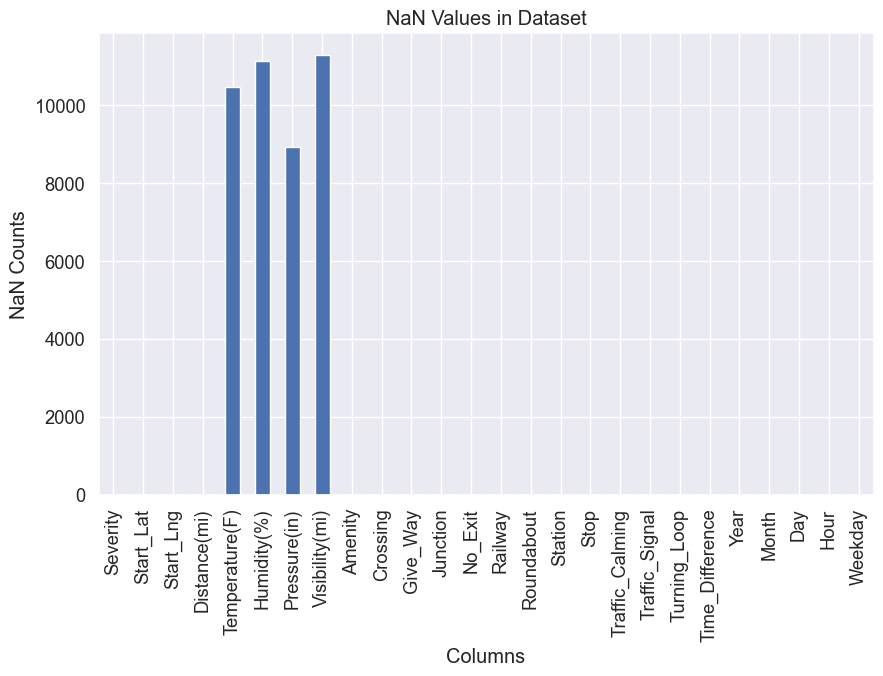

In [153]:
nan_counts = data.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

First we will compute the missing values for categorical variables and then for the continuous.

In [154]:
data.describe(include=['O'])

,Severity,Amenity,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Month,Day,Hour,Weekday
count,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000,500000
unique,4,2,2,2,2,2,2,2,2,2,2,2,1,12,31,24,7
top,2,False,False,False,False,False,False,False,False,False,False,False,False,12,23,7,4
freq,398142,493809,443747,497638,462993,498755,495680,499987,487002,485937,499534,425965,500000,54589,18159,37988,88766


It does not seem to be any missing value for the categorical values of the dataset, using the information available from the description. There are some Nan's, but these are detected by Python, so for the moment there is anything to worry about. Now, let's do it for numerical variables

In [155]:
data.describe(include=['int', 'float'])

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Time_Difference,Year
count,500000.000000,500000.000000,500000.000000,489534.000000,488870.000000,491072.000000,488709.000000,500000.000000,500000.000000
mean,36.206421,-94.736583,0.564317,61.646254,64.834921,29.536621,9.091540,6532.913214,2019.906596
std,5.071411,17.405761,1.774872,19.000133,22.826158,1.008666,2.708083,7566.691113,1.913944
min,24.562117,-124.497420,0.000000,-77.800000,1.000000,0.120000,0.000000,0.000000,2016.000000
25%,33.416823,-117.233047,0.000000,49.000000,48.000000,29.370000,10.000000,1890.000000,2018.000000
50%,35.832147,-87.794365,0.029000,64.000000,67.000000,29.860000,10.000000,4488.000000,2020.000000
75%,40.082443,-80.359601,0.465000,76.000000,84.000000,30.030000,10.000000,7485.000000,2022.000000
max,48.999569,-67.484130,193.479996,207.000000,100.000000,38.440000,130.000000,86399.000000,2023.000000


The Distance variable contains some 0's, it cannot be since if there has been an accident, the lenght of the road affected by it is greater than 0. The temperature of 200 F is not possible here, so it is also a Nan, the same with temperatures smaller then -40 F.The humidity percentage contains some 1, it is very low and cannot be real so we compute it as a missing value, the same for one of 100%. The minimum of the pressure (0.12 in) is very low for a place in the Earth, so there are also missing values there. A visibility of 0 miles is also a missing value, although it could be due to a climatological adversity, the same for 130 miles.

In order to visualize if there are wrong values in Start_Lat and Start_Lng, we will plot them. Map of USA should be seen.

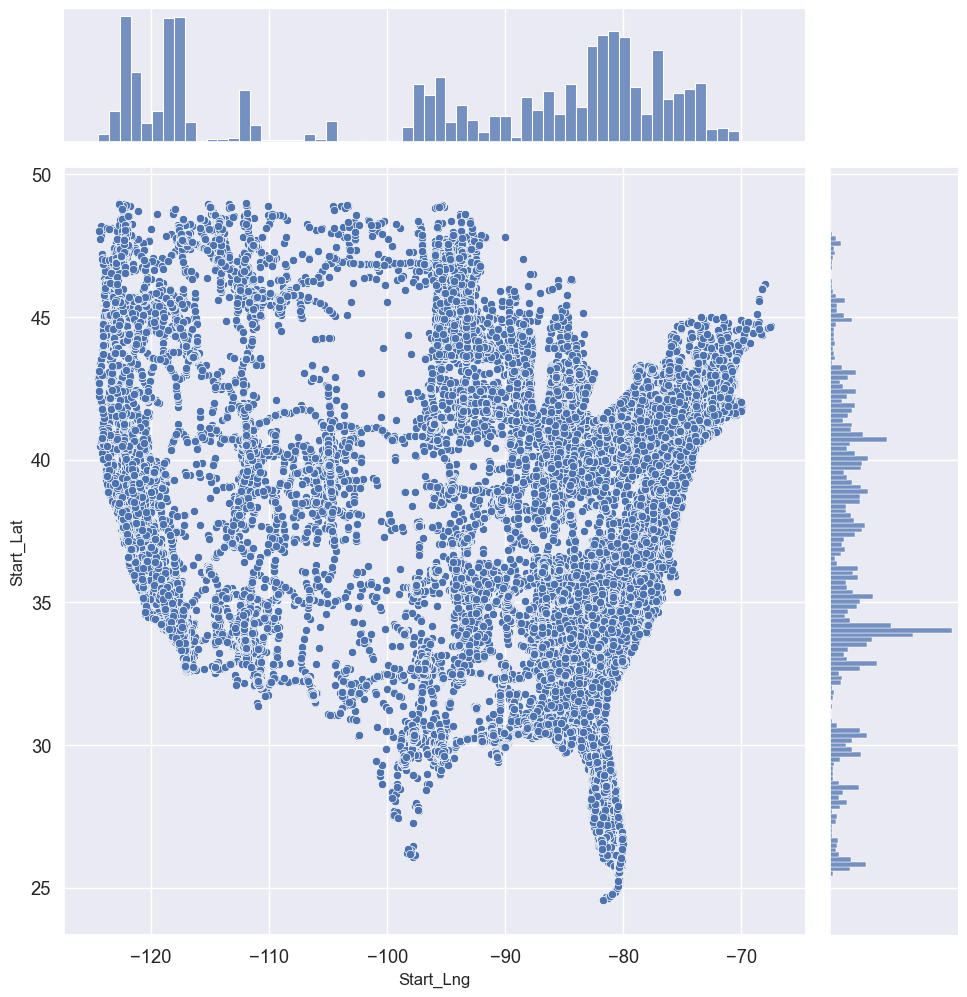

In [156]:
# plt.scatter(data['Start_Lng'], data['Start_Lat'])
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.title('Accident Locations')
# plt.show()

sns.jointplot(y=data.Start_Lat, x=data.Start_Lng.values,height=10)
plt.ylabel('Start_Lat', fontsize=12)
plt.xlabel('Start_Lng', fontsize=12)
plt.show()

As we can see in the map, it seems there is nothing wrong. Now, let's see the distribution of the numerical variables.

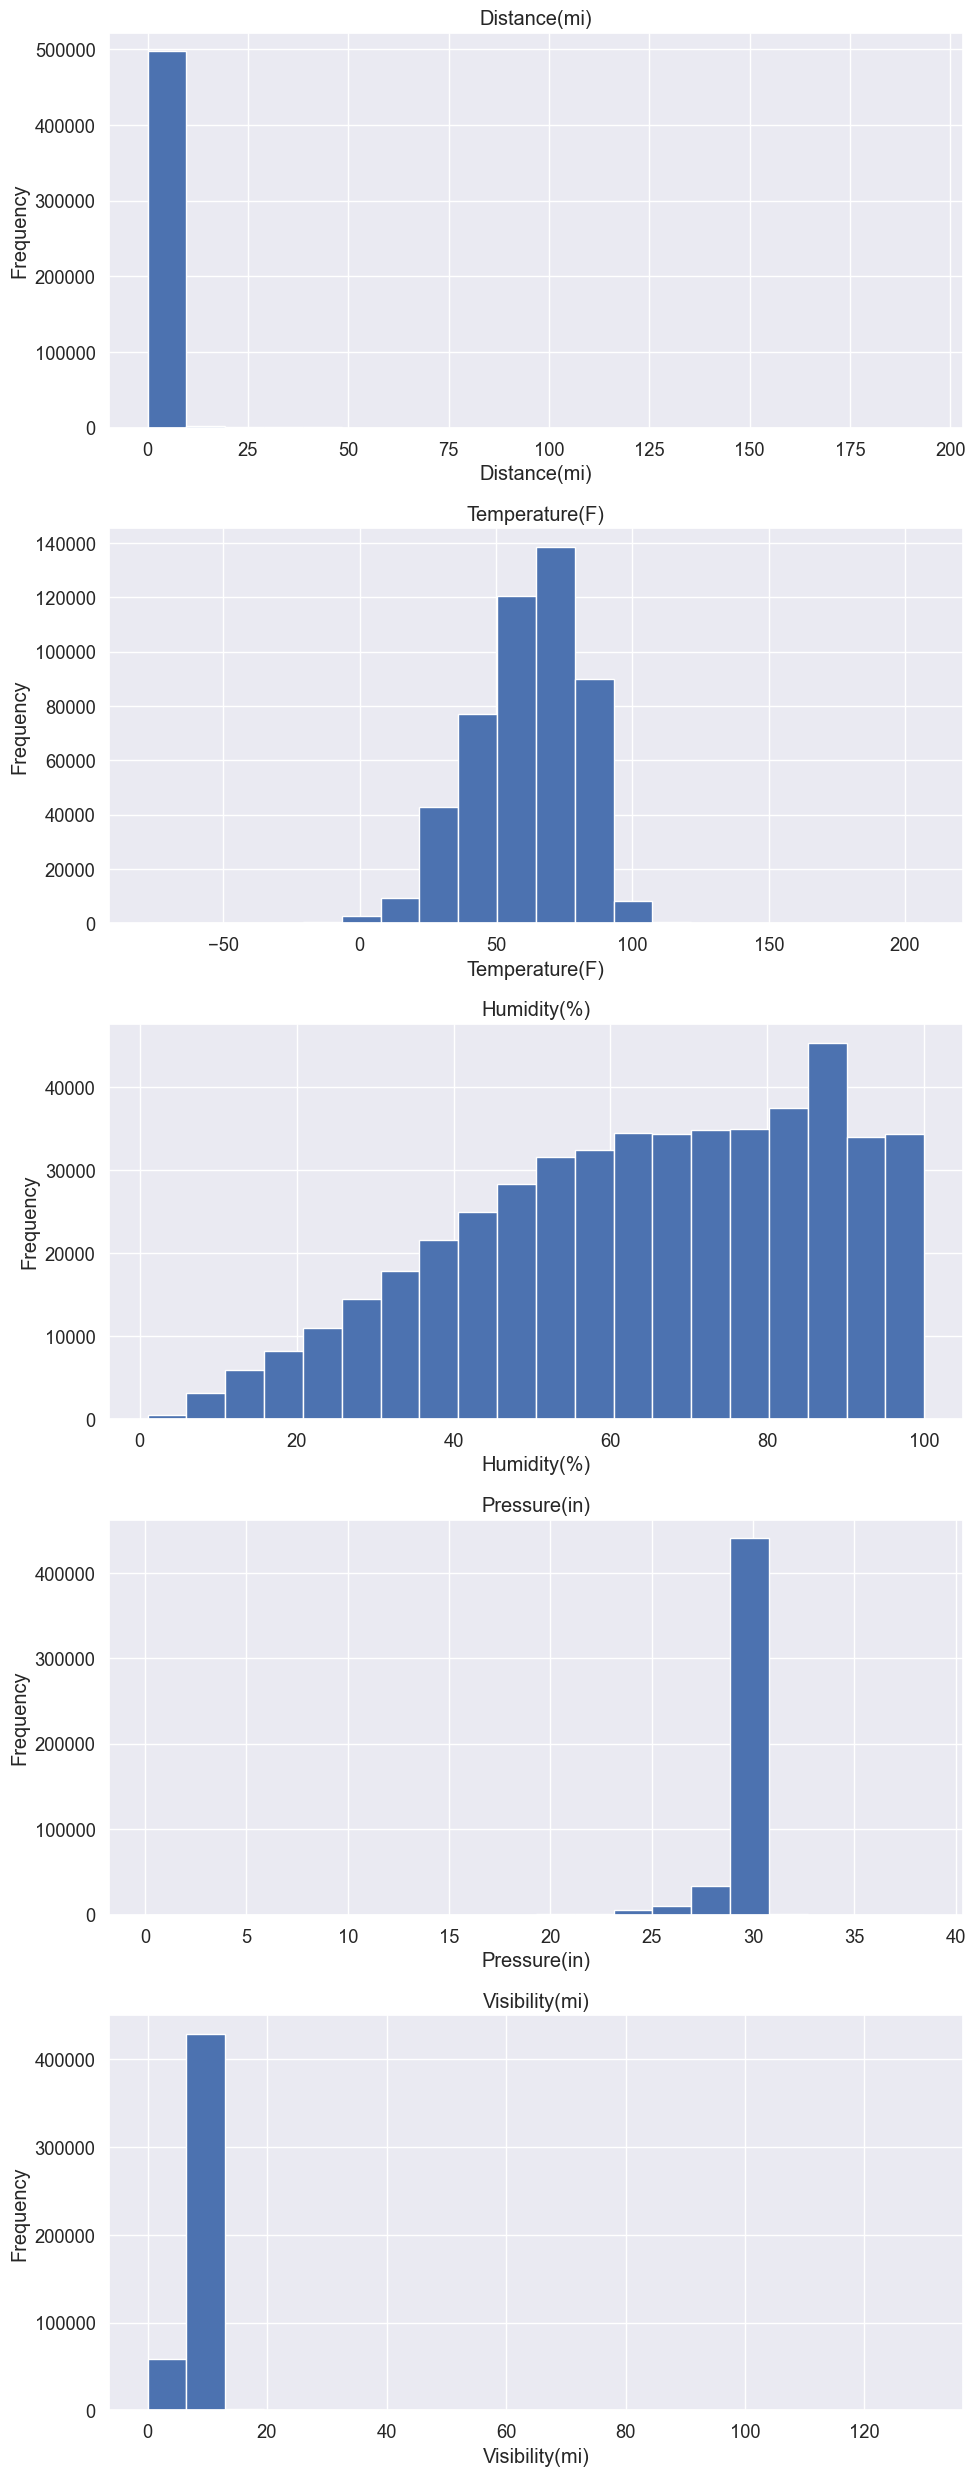

In [157]:
continuous_variables = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']

fig, axes = plt.subplots(len(continuous_variables), 1, figsize=(10, len(continuous_variables)*5))
for i, var in enumerate(continuous_variables):
    axes[i].hist(data[var].dropna(), bins=20)
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The Distance variable contains some 0's, it cannot be since if there has been an accident, the lenght of the road affected by it is greater than 0.

<Axes: >

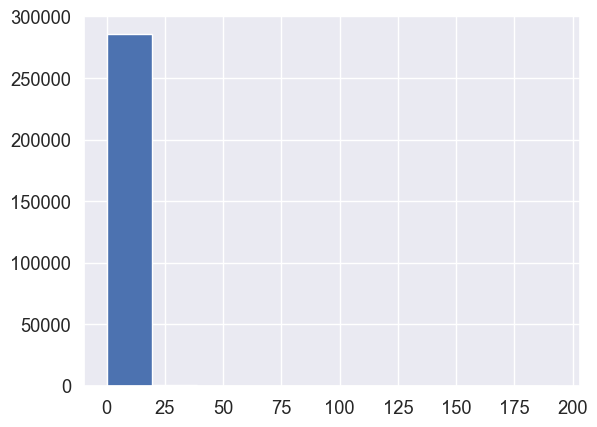

In [158]:
data['Distance(mi)'][data['Distance(mi)'] != 0].hist()

The temperature of 135 F is not possible here since the hottest temperature in the USA has been 134n F, so it is also a Nan, the same with temperatures smaller then -40 F.

<Axes: >

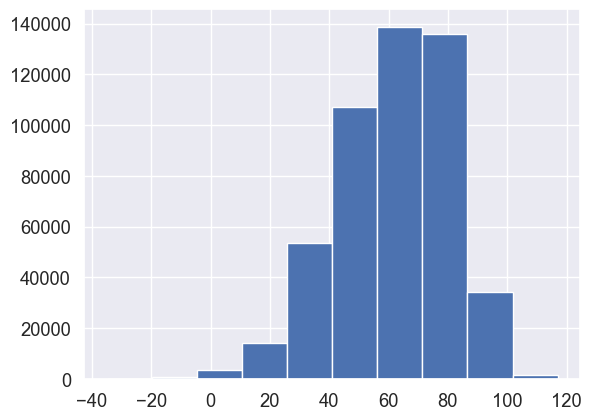

In [159]:
data['Temperature(F)'][(data['Temperature(F)'] > -40) & (data['Temperature(F)'] < 135)].hist()

The humidity percentage contains some 1, it is very low and cannot be real so we compute it as a missing value, the same for one of 100%.

<Axes: >

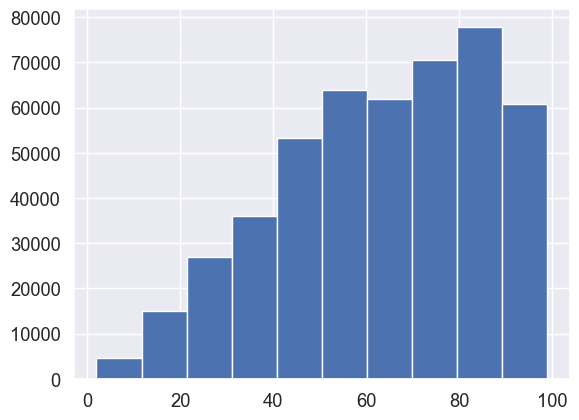

In [160]:
data['Humidity(%)'][(data['Humidity(%)'] !=1)&(data['Humidity(%)'] != 100)].hist()

The minimum of the pressure we will consider is a missing values is lower or equal than 20 (in). In fact, we are in a extreme case since the minimum pressure in the Earth is 25.69 in, but due to other factors such as storms, the pressure can be lower than this value. 

<Axes: >

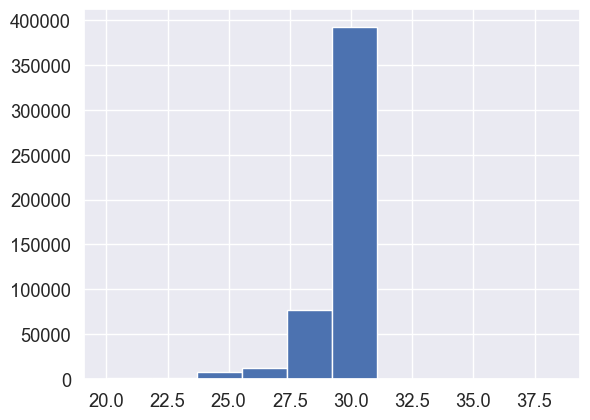

In [161]:
data['Pressure(in)'][data['Pressure(in)']>=20].hist()

A visibility of 0 miles is also a missing value, although it could be due to a climatological adversity. The same reasoning is applied to the visibility of 30 miles or greater. Nobody is able to see 30 miles away, even they are descending from the top of a mountain.

<Axes: >

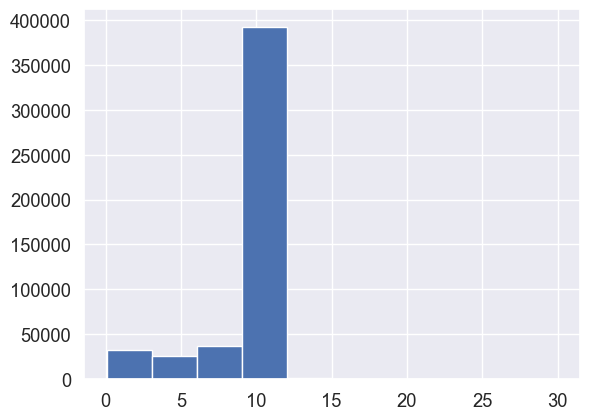

In [162]:
data['Visibility(mi)'][(data['Visibility(mi)'] != 0) & (data['Visibility(mi)'] <= 30)].hist()

In fact, let's count how many variables are in there.

In [163]:
((data['Visibility(mi)'] == 0) | (data['Visibility(mi)'] > 30)).value_counts()

Visibility(mi)
False    499077
True        923
Name: count, dtype: int64

In [164]:
data['Distance(mi)'][(data['Distance(mi)'] == 0)] = np.nan
data['Temperature(F)'][(data['Temperature(F)'] >= 135)|(data['Temperature(F)'] <= -40)] = np.nan
data['Humidity(%)'][(data['Humidity(%)'] == 1)|(data['Humidity(%)'] == 100)] = np.nan
data['Pressure(in)'][(data['Pressure(in)'] < 20)] = np.nan
data['Visibility(mi)'][(data['Visibility(mi)'] == 0)|(data['Visibility(mi)'] >= 30)] = np.nan

C:\Users\mique\AppData\Local\Temp\ipykernel_1128\2606743847.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['Distance(mi)'][(data['Distance(mi)'] == 0)] = np.nan
C:\Users\mique\AppData\Local\Temp\ipykernel_1128\2606743847.py:1: Sett

Now, let's visualise again the variables with Nan values

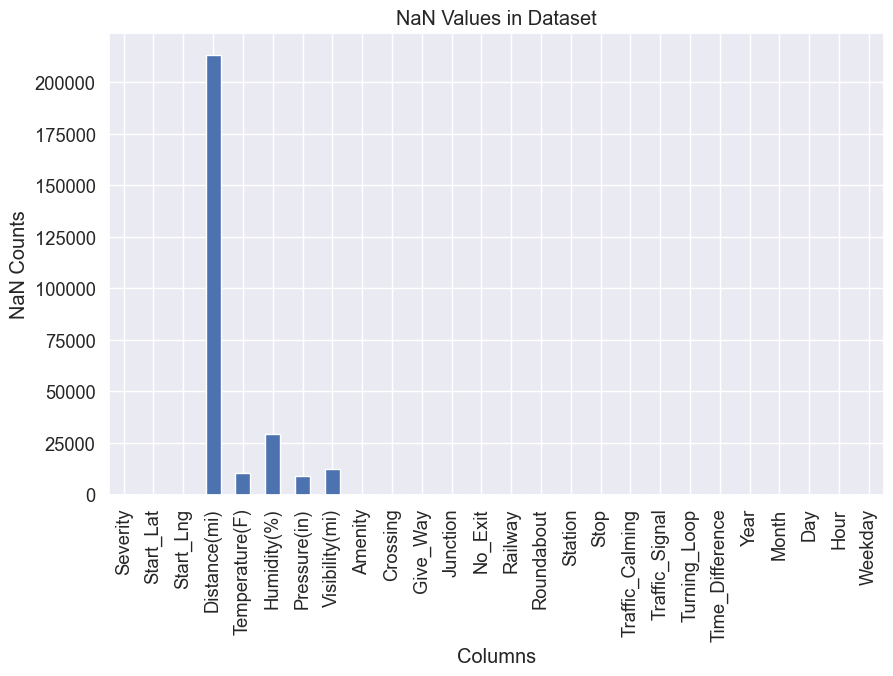

In [165]:
nan_counts = data.isna().sum()
nan_counts.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Columns')
plt.ylabel('NaN Counts')
plt.title('NaN Values in Dataset')
plt.show()

Now that we have seen some missing values in our data, we will set no NA the values seen here in order to impute a prediction using the KNN algorithm.

In [166]:
columns_with_nan = ['Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']
subset_data = data.drop(columns=columns_with_nan)

Let's see everything is correct.

In [167]:
data.shape

(500000, 26)

In [168]:
subset_data.shape

(500000, 21)

In [169]:
rows_not_missing = data['Distance(mi)'].notna() & data['Temperature(F)'].notna() &  data['Humidity(%)'].notna() & data['Pressure(in)'].notna() & data['Visibility(mi)'].notna()
data_without_missing = subset_data[rows_not_missing]
data_without_missing.shape

(267263, 21)

Rows have decreased. Now, let's compute the imputation.

In [170]:
knn_regressor = KNeighborsRegressor(n_neighbors=1)
knn_classifier = KNeighborsClassifier(n_neighbors=1)

for column in columns_with_nan:
    
    rows_column_missing = subset_data[data[column].isna()]

    if data[column].dtype == 'object':
        knn = knn_classifier
    else:
        knn = knn_regressor

    knn.fit(data_without_missing, data[column][rows_not_missing])
    imputed_values = knn.predict(rows_column_missing)

    data[column][data[column].isna()] = imputed_values

C:\Users\mique\AppData\Local\Temp\ipykernel_1128\604027489.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data[column][data[column].isna()] = imputed_values
C:\Users\mique\AppData\Local\Temp\ipykernel_1128\604027489.py:16: SettingWithC

Now, let's check if everything is ok

In [171]:
data.isna().sum() 

Severity           0
Start_Lat          0
Start_Lng          0
Distance(mi)       0
Temperature(F)     0
Humidity(%)        0
Pressure(in)       0
Visibility(mi)     0
Amenity            0
Crossing           0
Give_Way           0
Junction           0
No_Exit            0
Railway            0
Roundabout         0
Station            0
Stop               0
Traffic_Calming    0
Traffic_Signal     0
Turning_Loop       0
Time_Difference    0
Year               0
Month              0
Day                0
Hour               0
Weekday            0
dtype: int64

Our data has no Nan's, those who where have been imputated, now let's focus on the outliers.

## Section 4: Dealing with outliers

It is important to identify these values, in order to take them into account when fitting models. Some of these models are sensitive to outliers. 

### Distance
First let's see the variable Distance(mi), this has a clear outlier, it's max.

array([<Axes: title={'center': 'Distance(mi)'}>], dtype=object)

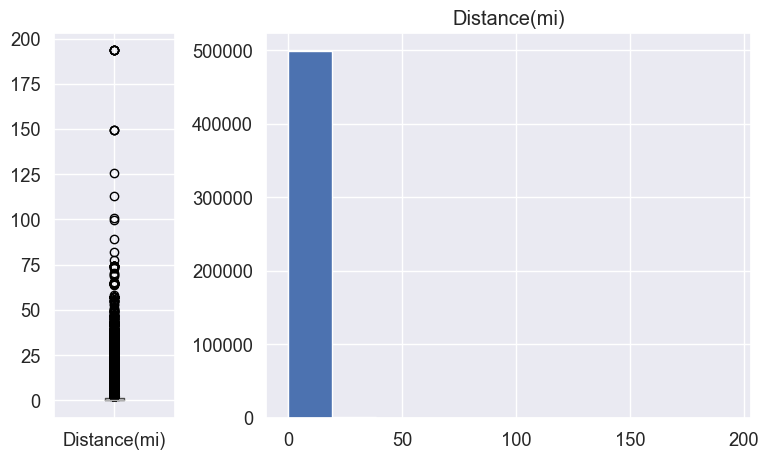

In [172]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data.boxplot(column='Distance(mi)',ax=axes[0])
data.hist(column='Distance(mi)',ax=axes[1])

There are obviously a lot of values that do not represent the correct distribution of our variable.

Let's use the IQR to improve this. Using LocalOutlierFactor, we have seen that it requires a lot of computational time and does not improve the results given by the IQR, so we will use this strategy.

array([<Axes: title={'center': 'Distance(mi)'}>], dtype=object)

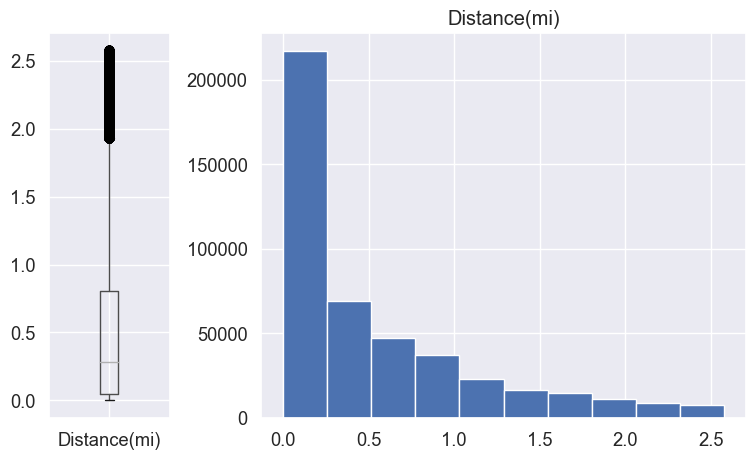

In [173]:
Q1 = data['Distance(mi)'].quantile(0.25)
Q3 = data['Distance(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data['Distance(mi)'] < (Q1 - 1.5 * IQR)
big_out = data['Distance(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data[~(small_out | big_out)].boxplot(column='Distance(mi)',ax=axes[0])
data[~(small_out | big_out)].hist(column='Distance(mi)',ax=axes[1])

It seems it has a great result, let's save the transformation. Let's proceed to use this routine for all other continuous variables with outliers.

In [174]:
data = data[~(small_out | big_out)]

### Visibility

array([<Axes: title={'center': 'Visibility(mi)'}>], dtype=object)

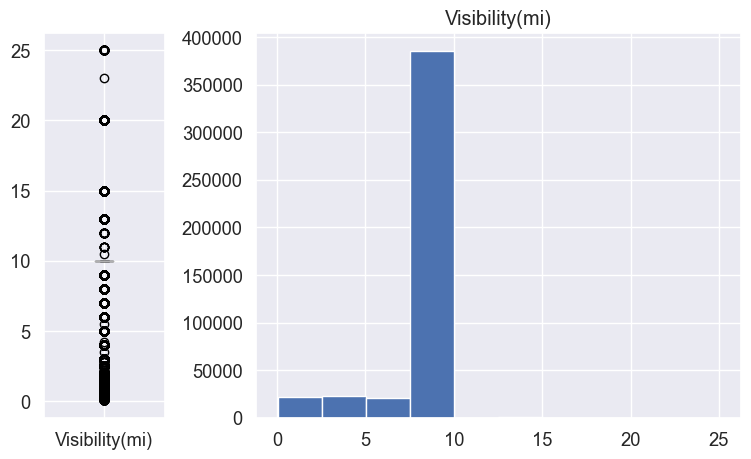

In [175]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data.boxplot(column='Visibility(mi)',ax=axes[0])
data.hist(column='Visibility(mi)',ax=axes[1])

array([<Axes: title={'center': 'Visibility(mi)'}>], dtype=object)

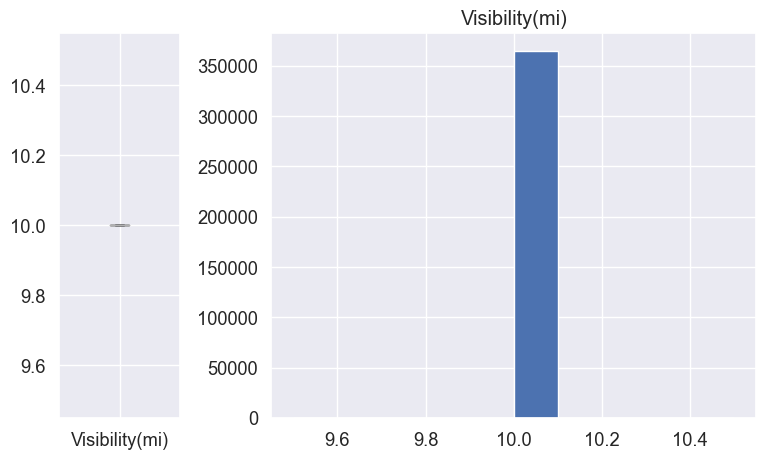

In [176]:
Q1 = data['Visibility(mi)'].quantile(0.25)
Q3 = data['Visibility(mi)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data['Visibility(mi)'] < (Q1 - 1.5 * IQR)
big_out = data['Visibility(mi)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data[~(small_out | big_out)].boxplot(column='Visibility(mi)',ax=axes[0])
data[~(small_out | big_out)].hist(column='Visibility(mi)',ax=axes[1])

In [177]:
data = data[~(small_out | big_out)]

### Temperature

array([<Axes: title={'center': 'Temperature(F)'}>], dtype=object)

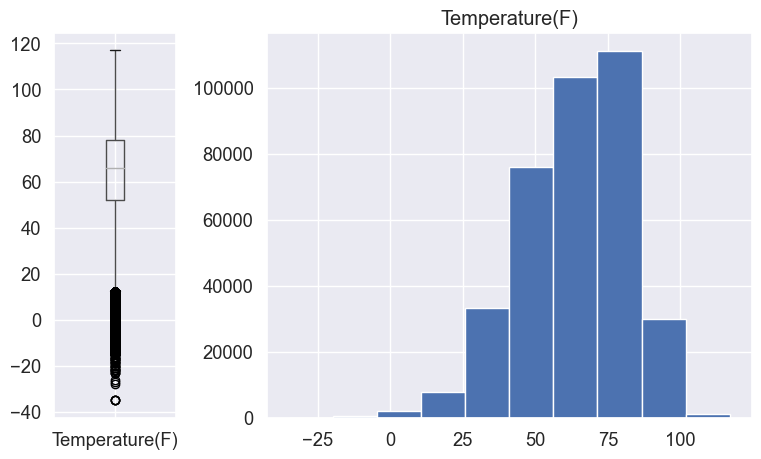

In [178]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data.boxplot(column='Temperature(F)',ax=axes[0])
data.hist(column='Temperature(F)',ax=axes[1])

It seems well distributed. However, it seems there are some outliers.

array([<Axes: title={'center': 'Temperature(F)'}>], dtype=object)

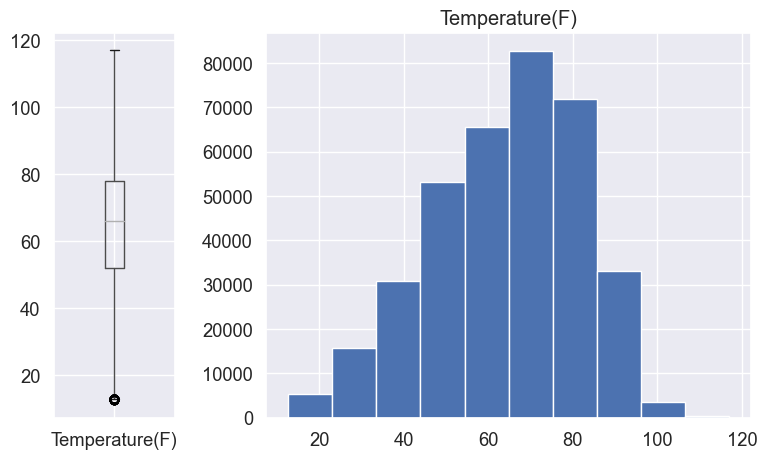

In [179]:
Q1 = data['Temperature(F)'].quantile(0.25)
Q3 = data['Temperature(F)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data['Temperature(F)'] < (Q1 - 1.5 * IQR)
big_out = data['Temperature(F)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data[~(small_out | big_out)].boxplot(column='Temperature(F)',ax=axes[0])
data[~(small_out | big_out)].hist(column='Temperature(F)',ax=axes[1])

### Time Difference

array([<Axes: title={'center': 'Time_Difference'}>], dtype=object)

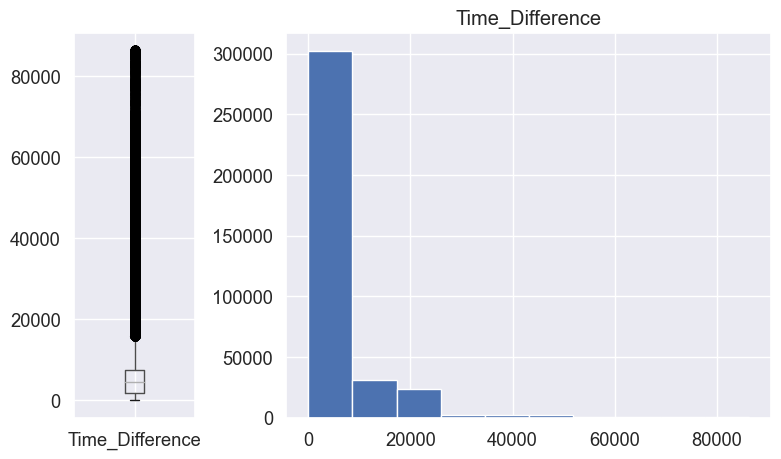

In [180]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data.boxplot(column='Time_Difference',ax=axes[0])
data.hist(column='Time_Difference',ax=axes[1])

There are a lot of values with a very high value, we aplly IQR here too.

array([<Axes: title={'center': 'Time_Difference'}>], dtype=object)

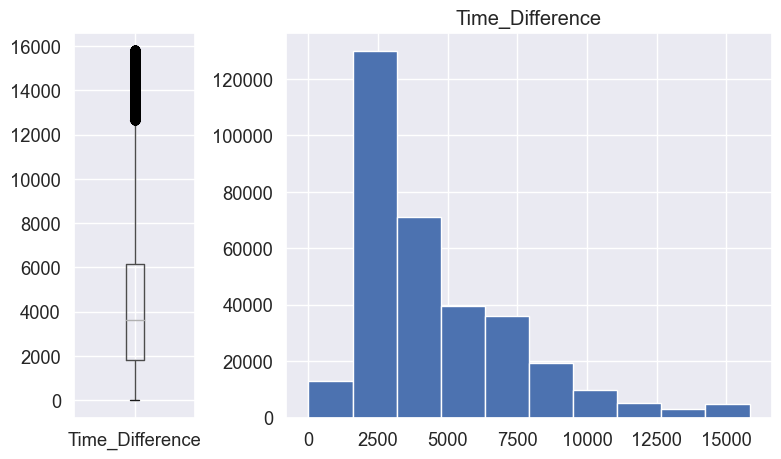

In [181]:
Q1 = data['Time_Difference'].quantile(0.25)
Q3 = data['Time_Difference'].quantile(0.75)
IQR = Q3 - Q1

small_out = data['Time_Difference'] < (Q1 - 1.5 * IQR)
big_out = data['Time_Difference'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data[~(small_out | big_out)].boxplot(column='Time_Difference',ax=axes[0])
data[~(small_out | big_out)].hist(column='Time_Difference',ax=axes[1])

In [182]:
data = data[~(small_out | big_out)]

In [183]:
data.shape

(331789, 26)

Now it seems we have all our data without outliers, and we have reduced our samples from 500000 to 330000 aproximately. Let's proceed with more preprocessing.

It gives better results.

In [184]:
data.describe(include = ['int', 'float'])

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Time_Difference,Year
count,331789.000000,331789.000000,331789.000000,331789.000000,331789.000000,331789.000000,331789.0,331789.000000,331789.000000
mean,35.890571,-94.835350,0.518361,63.632544,59.808637,29.543311,10.0,4515.928192,2020.013385
std,5.078565,17.396212,0.609851,18.446978,21.270852,0.996081,0.0,2986.893044,1.870741
min,24.562117,-124.494330,0.001000,-35.000000,2.000000,20.010000,10.0,0.000000,2016.000000
25%,32.932392,-117.217758,0.043000,51.100000,45.000000,29.380000,10.0,1793.000000,2019.000000
50%,35.438332,-87.825340,0.264000,66.000000,61.000000,29.860000,10.0,3611.000000,2020.000000
75%,39.805608,-80.368416,0.796000,78.000000,77.000000,30.040000,10.0,6141.000000,2022.000000
max,48.991585,-67.484130,2.576000,117.000000,99.000000,38.440000,10.0,15828.000000,2023.000000


### Humidity

array([<Axes: title={'center': 'Humidity(%)'}>], dtype=object)

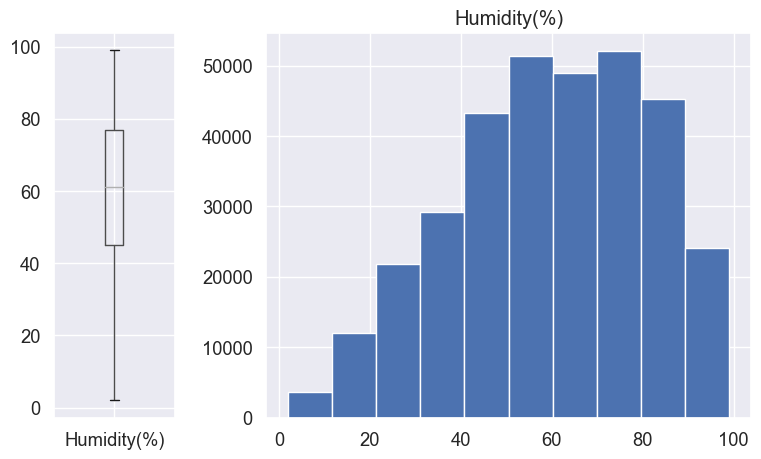

In [185]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data.boxplot(column='Humidity(%)',ax=axes[0])
data.hist(column='Humidity(%)',ax=axes[1])

Humidity is well distributred, so we are not gonna change anything.

### Pressure

array([<Axes: title={'center': 'Pressure(in)'}>], dtype=object)

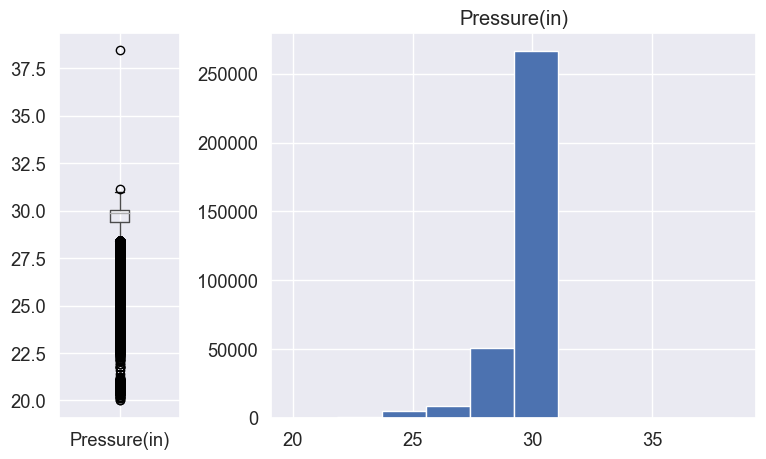

In [186]:
fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data.boxplot(column='Pressure(in)',ax=axes[0])
data.hist(column='Pressure(in)',ax=axes[1])

array([<Axes: title={'center': 'Pressure(in)'}>], dtype=object)

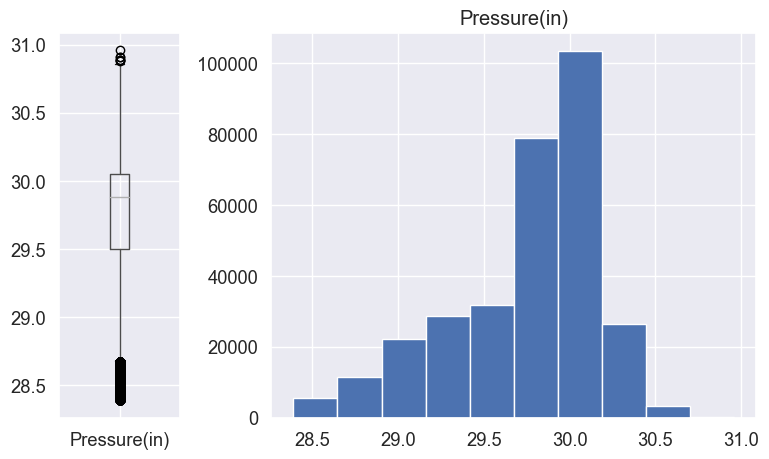

In [187]:
Q1 = data['Pressure(in)'].quantile(0.25)
Q3 = data['Pressure(in)'].quantile(0.75)
IQR = Q3 - Q1

small_out = data['Pressure(in)'] < (Q1 - 1.5 * IQR)
big_out = data['Pressure(in)'] > (Q3 + 1.5 * IQR)

fig, axes = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 4]}, figsize=(9, 5))
data[~(small_out | big_out)].boxplot(column='Pressure(in)',ax=axes[0])
data[~(small_out | big_out)].hist(column='Pressure(in)',ax=axes[1])

Pressure could be better distributed.

In [188]:
data = data[~(small_out | big_out)]

### Final step

Finally, let's see how many variables we have eliminated

In [189]:
data.shape

(311924, 26)

As we can see, now we have around 300000 rows, which is a good number to work with, but it is also a good to remember that we started with 500000.

## Section 5: Second Feature selection

Even though, there are not so many variables, we will do a second selection of the features that we believe are the most important for our model. Notice that the selection is based on the data description and the importance of the features in the model according to the predictor, which is Severity.

In [190]:
data.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Amenity', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Time_Difference', 'Year', 'Month', 'Day', 'Hour', 'Weekday'],
      dtype='object')

In [191]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 311924 entries, 0 to 499999
Data columns (total 26 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Severity         311924 non-null  object 
 1   Start_Lat        311924 non-null  float64
 2   Start_Lng        311924 non-null  float64
 3   Distance(mi)     311924 non-null  float64
 4   Temperature(F)   311924 non-null  float64
 5   Humidity(%)      311924 non-null  float64
 6   Pressure(in)     311924 non-null  float64
 7   Visibility(mi)   311924 non-null  float64
 8   Amenity          311924 non-null  object 
 9   Crossing         311924 non-null  object 
 10  Give_Way         311924 non-null  object 
 11  Junction         311924 non-null  object 
 12  No_Exit          311924 non-null  object 
 13  Railway          311924 non-null  object 
 14  Roundabout       311924 non-null  object 
 15  Station          311924 non-null  object 
 16  Stop             311924 non-null  object 
 

First of all, let's print the correlation matrix for numerical variables in order to see if there variables that are highly correlated with target.

In [192]:
# plot correlation matrix
numerical_columns = [column for column in data.columns if data[column].dtype == 'float64' or data[column].dtype == 'int64']

print(numerical_columns)

['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Time_Difference', 'Year']


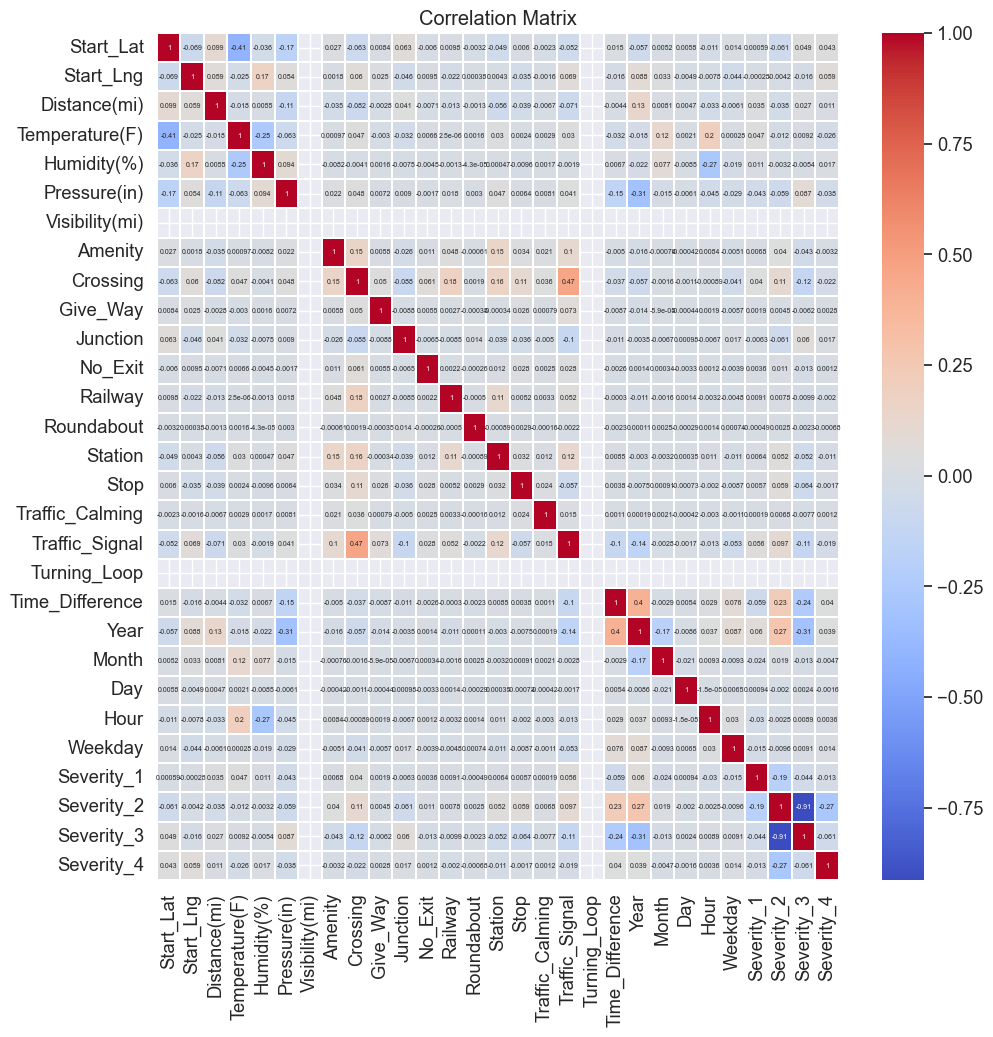

In [195]:
data_encoded = pd.get_dummies(data, columns = ['Severity'])
corr_matrix = data_encoded.corr()
plt.figure(figsize=(11, 11))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.1, annot_kws={"size": 5})
plt.title('Correlation Matrix')
plt.show()

By taking a look to the last 4 rows, we decide to get rid of Visibility and Turning Loop, since they have no correlation with the target variable.

In [196]:
data = data.drop(columns = ['Visibility(mi)', 'Turning_Loop'])

## Section 6: Feature extraction

## Section 7: Normalization

In order to make the data more suitable for the models, we will normalize the data. For this reason, we will force variables to have the same range.

In [198]:
numerical_columns = [column for column in data.columns if data[column].dtype == 'float64' or data[column].dtype == 'int64']

std_scaler = preprocessing.StandardScaler()

data[numerical_columns] = std_scaler.fit_transform(data[numerical_columns])

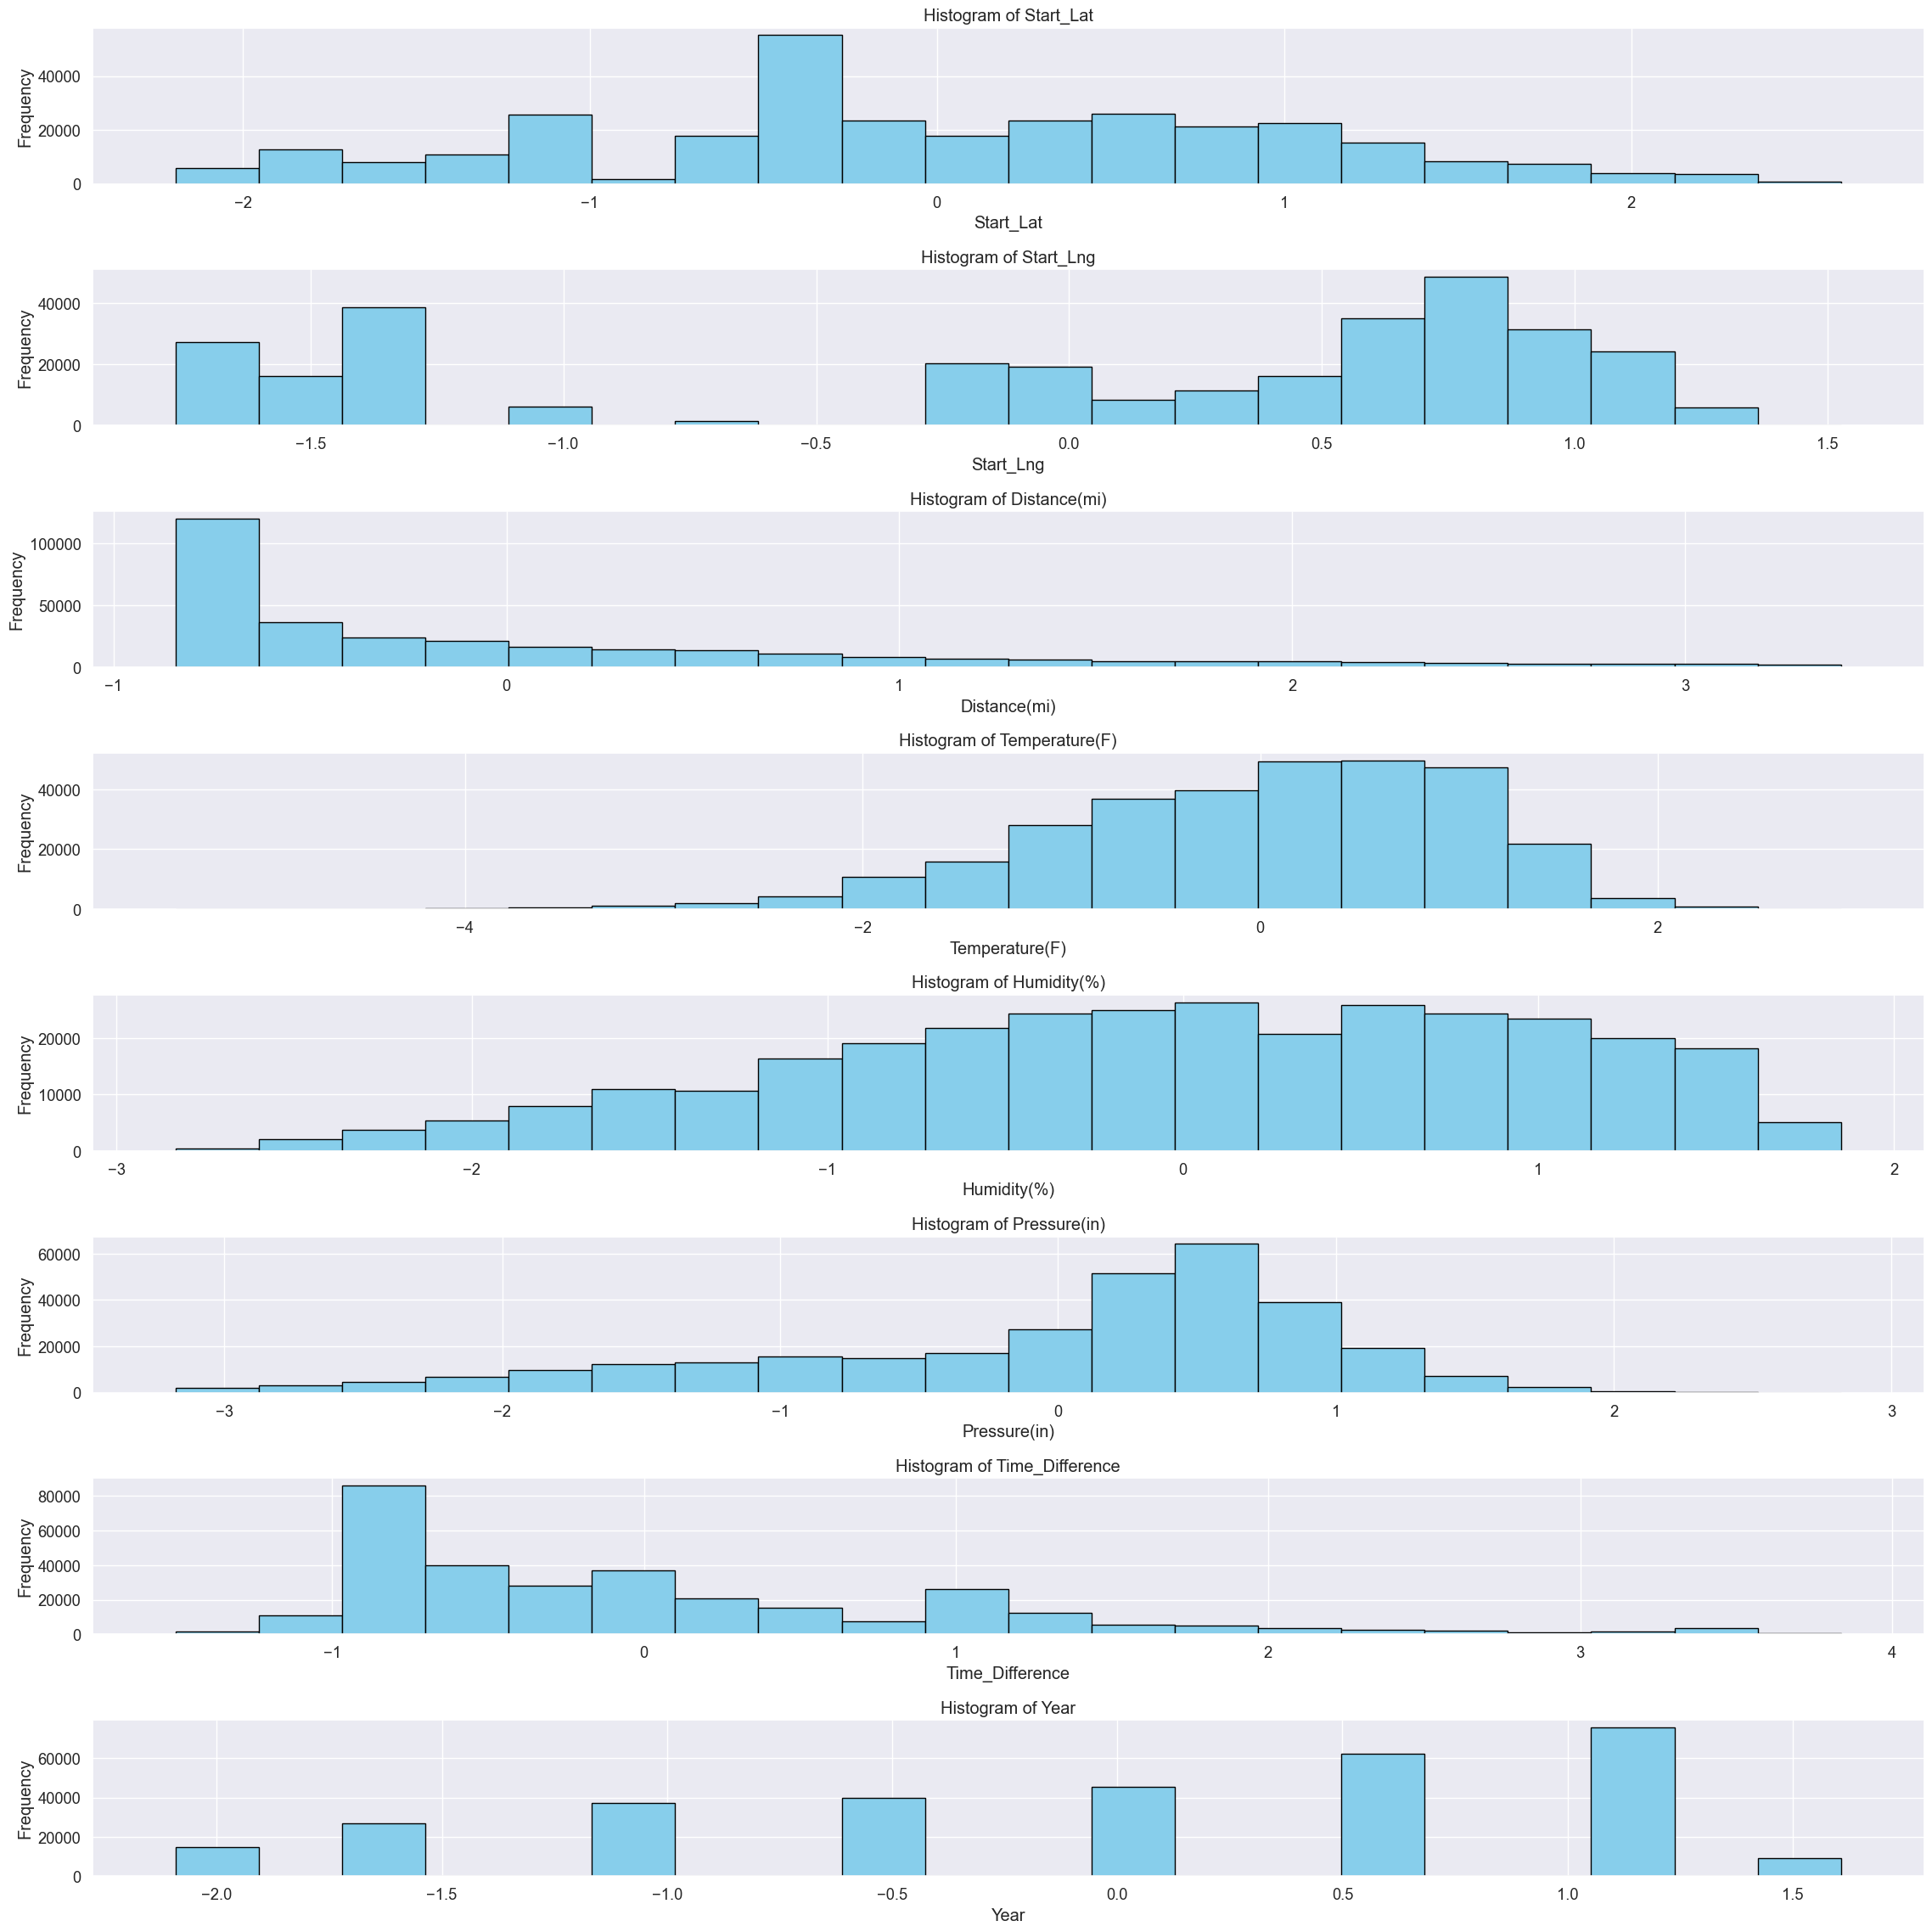

In [199]:
fig, axs = plt.subplots(len(numerical_columns), 1, figsize=(23, 23))

for i, var in enumerate(numerical_columns):
    axs[i].hist(data[var], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {var}')
    axs[i].set_xlabel(var)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()

plt.show()

As it can be seen, the data is now normalized. Furthermore, in some of these variables we can see a clear Normal distribution with it's mean and variance. So this transformation of the data has been well implemented. The variables that are not Gaussian do not show the same distribution, although they are centered in the 0.

In [201]:
data.describe()

,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Time_Difference,Year
count,3.119240e+05,3.119240e+05,3.119240e+05,3.119240e+05,3.119240e+05,3.119240e+05,3.119240e+05,3.119240e+05
mean,-7.426070e-18,5.045627e-18,6.241543e-18,-5.535383e-18,-1.308104e-17,2.869060e-17,-2.656073e-17,-2.699354e-18
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.193935e+00,-1.766871e+00,-8.423163e-01,-5.457154e+00,-2.833997e+00,-3.176205e+00,-1.501736e+00,-2.091518e+00
25%,-5.631085e-01,-1.345528e+00,-7.797564e-01,-6.614488e-01,-7.088271e-01,-5.874766e-01,-8.977228e-01,-1.034790e+00
50%,-9.570705e-02,4.157343e-01,-4.175673e-01,1.102739e-01,6.396202e-02,2.987547e-01,-2.903374e-01,2.193752e-02
75%,7.783094e-01,7.857263e-01,4.516866e-01,7.717504e-01,7.884518e-01,6.952266e-01,5.318756e-01,1.078665e+00
max,2.604347e+00,1.526215e+00,3.396943e+00,2.921549e+00,1.851037e+00,2.817518e+00,3.835229e+00,1.607029e+00


## Section 8: Ending preprocessing

Now, finally shuffle the data in order to avoid possible ordering biases.

In [202]:
np.random.seed(1234)
data = data.sample(frac=1).reset_index(drop = True)

In [203]:
data.to_csv('../data/clean_data.csv', index=False)